# From Insight to Action: Predicting Customer Churn to Optimize Retention Offers

In the competitive telecom industry, retaining existing customers is just as crucial as acquiring new ones. Customer churn—the rate at which users discontinue service—can significantly impact a company’s long-term revenue. To proactively address this challenge, Interconnect Telecom aims to implement a data-driven strategy for forecasting client churn and targeting customers likely to leave the company with timely retention offers such as discounts or adjustments in service offerings.

This project uses data from Interconnect’s past and present client base, including contract details, service usage, and personal demographics, to build a predictive model that identifies customers likely to terminate their contracts. By identifying relevant risk factors based on customers who have already left the company, Interconnect can target these customers with retention offers to decrease the likelihood they will discontinue serice before it happens.

The primary objective of this project is to develop a machine learning model that predicts churn with a high degree of accuracy, evaluated by the AUC-ROC metric. Given that predictions fall into either a yes or no binary, AUC-ROC is an ideal metric to use as it highlights the accuracy of these critical predictions.  This model will serve as a key tool in Interconnect’s retention strategy, helping to transform raw customer data into actionable business insights.

## Data Description & Exploration

In [131]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import lightgbm as lgb
from catboost import CatBoostClassifier

In [132]:
contracts = pd.read_csv('/datasets/final_provider/contract.csv')
customers = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [133]:
contracts

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [134]:
contracts.columns = map(str.lower, contracts.columns)

In [135]:
contracts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   begindate         7043 non-null   object 
 2   enddate           7043 non-null   object 
 3   type              7043 non-null   object 
 4   paperlessbilling  7043 non-null   object 
 5   paymentmethod     7043 non-null   object 
 6   monthlycharges    7043 non-null   float64
 7   totalcharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [136]:
contracts['begindate'] = pd.to_datetime(contracts['begindate'])

In [137]:
contracts['enddate'] = contracts['enddate'].replace('No', np.nan)
contracts['enddate'] = pd.to_datetime(contracts['enddate'])

In [138]:
contracts['totalcharges'] = contracts['totalcharges'].str.strip().replace('', np.nan)
contracts['totalcharges'] = contracts['totalcharges'].fillna(0).astype('float64')

In [139]:
contracts.describe()

,monthlycharges,totalcharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


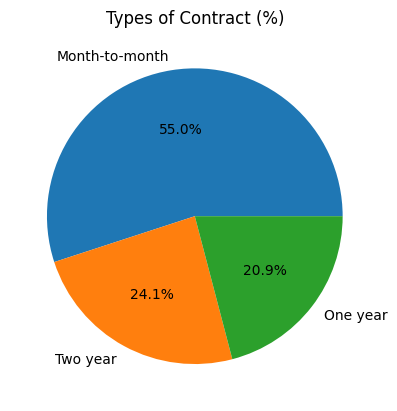

In [140]:
type_cat_counts = contracts['type'].value_counts()
plt.pie(type_cat_counts, labels=type_cat_counts.index, autopct='%1.1f%%')
plt.title('Types of Contract (%)')
plt.show()

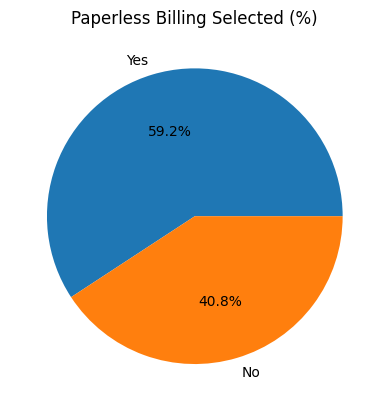

In [141]:
billing_cat_counts = contracts['paperlessbilling'].value_counts()
plt.pie(billing_cat_counts, labels=billing_cat_counts.index, autopct='%1.1f%%')
plt.title('Paperless Billing Selected (%)')
plt.show()

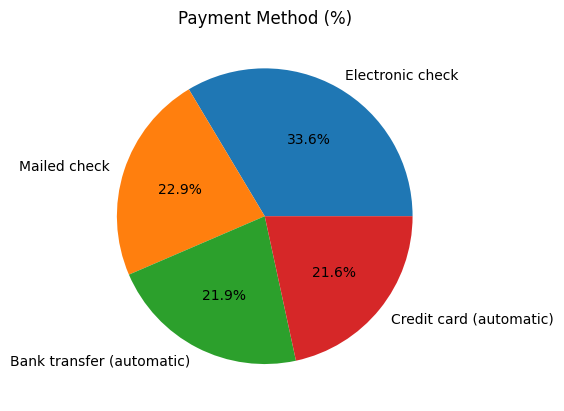

In [142]:
payment_cat_counts = contracts['paymentmethod'].value_counts()
plt.pie(payment_cat_counts, labels=payment_cat_counts.index, autopct='%1.1f%%')
plt.title('Payment Method (%)')
plt.show()

The contracts dataframe contains info on 7043 different contracts.  All data is intact, though some columns' datatype was converted to allow for more robust analysis.  It includes beginning and end dates (if applicable) for a customer's service, the type of contract they have/had (month-to-month, one year, or two year), whether or not they use(d) paperless billing, how they pay/paid their bill, their monthly payment, and how much revenue the customer (has) generated over the life of their contract as of February 1, 2020.  As of this date, 1869 customers have terminated service, representing 26.5% of the dataset.

Monthly bills range from \\$18.25 to \\$118.75 with the majority of bills falling between \\$35.50 and \\$89.85 and an average bill of \\$64.76.  The average customer (has) generated \\$2279.73 for Interconnect, though the dataset contains new customers who have yet to generate any revenue and longterm customers who have generated over \\$8k in revenue.

55% of customers have/had a month-to-month contract with the remainder roughly divided between one- and two-year contracts.  Paperless billing is preferred by 59% of customers.  Electronic check is slightly more popular than other payment methods, with customers equally divided between other options (mailed check, bank transfer, and credit card).

In [143]:
customers

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [144]:
customers.columns = map(str.lower, customers.columns)

In [145]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [146]:
customers.describe()

,seniorcitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


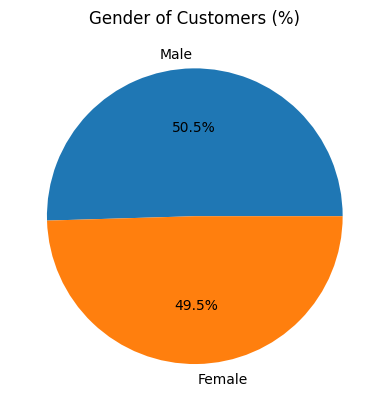

In [147]:
gender_cat_counts = customers['gender'].value_counts()
plt.pie(gender_cat_counts, labels=gender_cat_counts.index, autopct='%1.1f%%')
plt.title('Gender of Customers (%)')
plt.show()

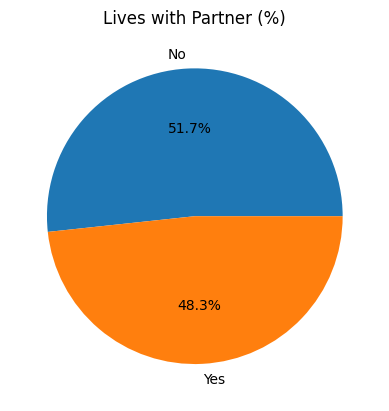

In [148]:
partner_cat_counts = customers['partner'].value_counts()
plt.pie(partner_cat_counts, labels=partner_cat_counts.index, autopct='%1.1f%%')
plt.title('Lives with Partner (%)')
plt.show()

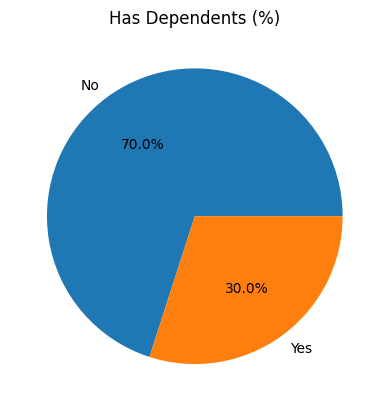

In [149]:
dependents_cat_counts = customers['dependents'].value_counts()
plt.pie(dependents_cat_counts, labels=dependents_cat_counts.index, autopct='%1.1f%%')
plt.title('Has Dependents (%)')
plt.show()

The customers dataset includes information on the customer attached to each contract via a unique customer ID.  Of the 7043 customers, 16% are senior citizens and 70% do not have dependents.  Customers are split evenly female-male and nearly evenly on whether or not they have a partner (52% no, 48% yes).

In [150]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [151]:
internet.columns = map(str.lower, internet.columns)

In [152]:
internet['has_internet'] = 1

In [153]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
 8   has_internet      5517 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 388.0+ KB


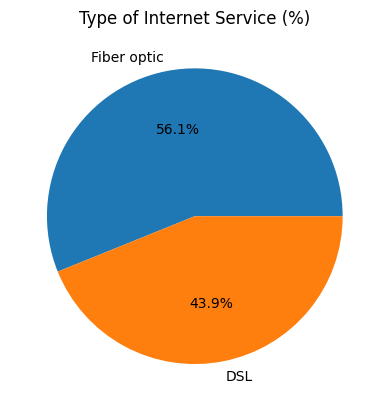

In [154]:
service_cat_counts = internet['internetservice'].value_counts()
plt.pie(service_cat_counts, labels=service_cat_counts.index, autopct='%1.1f%%')
plt.title('Type of Internet Service (%)')
plt.show()

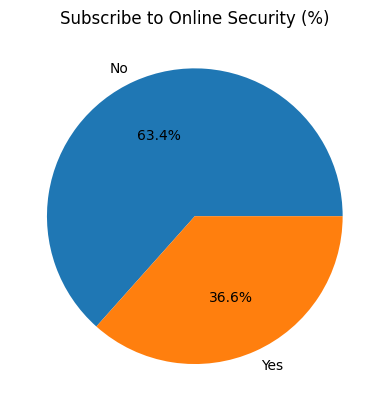

In [155]:
os_cat_counts = internet['onlinesecurity'].value_counts()
plt.pie(os_cat_counts, labels=os_cat_counts.index, autopct='%1.1f%%')
plt.title('Subscribe to Online Security (%)')
plt.show()

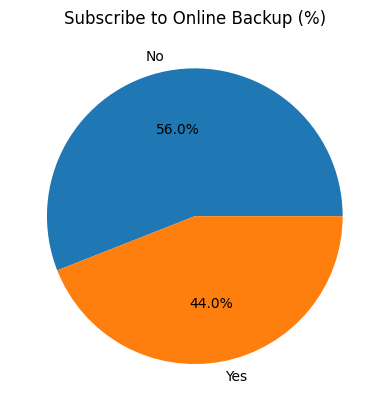

In [156]:
ob_cat_counts = internet['onlinebackup'].value_counts()
plt.pie(ob_cat_counts, labels=ob_cat_counts.index, autopct='%1.1f%%')
plt.title('Subscribe to Online Backup (%)')
plt.show()

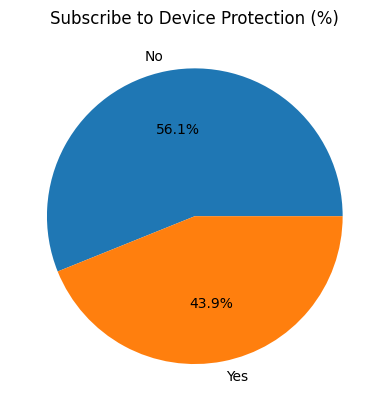

In [157]:
dp_cat_counts = internet['deviceprotection'].value_counts()
plt.pie(dp_cat_counts, labels=dp_cat_counts.index, autopct='%1.1f%%')
plt.title('Subscribe to Device Protection (%)')
plt.show()

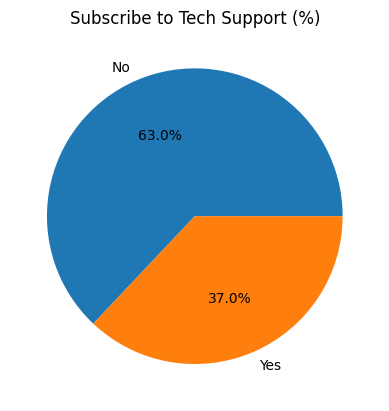

In [158]:
ts_cat_counts = internet['techsupport'].value_counts()
plt.pie(ts_cat_counts, labels=ts_cat_counts.index, autopct='%1.1f%%')
plt.title('Subscribe to Tech Support (%)')
plt.show()

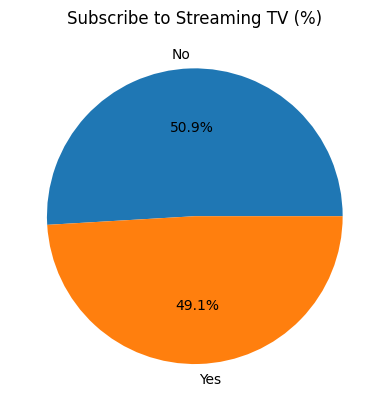

In [159]:
stv_cat_counts = internet['streamingtv'].value_counts()
plt.pie(stv_cat_counts, labels=stv_cat_counts.index, autopct='%1.1f%%')
plt.title('Subscribe to Streaming TV (%)')
plt.show()

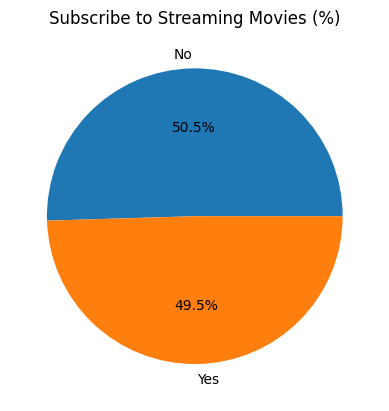

In [160]:
sm_cat_counts = internet['streamingmovies'].value_counts()
plt.pie(sm_cat_counts, labels=sm_cat_counts.index, autopct='%1.1f%%')
plt.title('Subscribe to Streaming Movies (%)')
plt.show()

5517 customers have internet service.  44% have DSL while 56% have fiber optic.  Most customers do not subscribe to online security (63%), online backup (56%), device protection (56%), or tech support (63%).  However, customers are split nearly evenly on whether or not they subscribe to streaming tv (51-49 no-yes) and streaming movies (50-50).

In [161]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [162]:
phone.columns = map(str.lower, phone.columns)

In [163]:
phone['has_phone'] = 1

In [164]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
 2   has_phone      6361 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 149.2+ KB


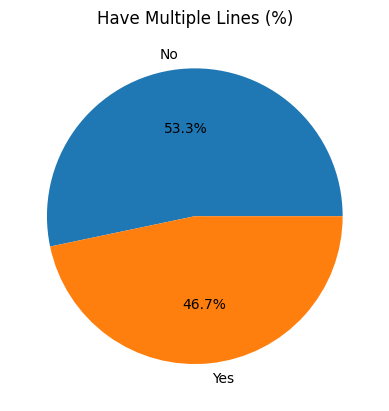

In [165]:
ml_cat_counts = phone['multiplelines'].value_counts()
plt.pie(ml_cat_counts, labels=ml_cat_counts.index, autopct='%1.1f%%')
plt.title('Have Multiple Lines (%)')
plt.show()

6361 customers subscribe to phone service and 47% of them have multiple lines.

In [166]:
combined_df = contracts.merge(customers, on='customerid', how='outer')
combined_df = combined_df.merge(internet, on='customerid', how='outer')
combined_df = combined_df.merge(phone, on='customerid', how='outer')
combined_df

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,has_internet,multiplelines,has_phone
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,1.0,NaN,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,1.0,No,1.0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,1.0,No,1.0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,1.0,No,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,1.0,Yes,1.0
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,1.0,Yes,1.0
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,DSL,Yes,No,No,No,No,No,1.0,NaN,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,...,Fiber optic,No,No,No,No,No,No,1.0,Yes,1.0


## Data Preparation

In [167]:
#creating target--active
combined_df['active'] = np.where(combined_df['enddate'].isnull(), 1, 0)
combined_df

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,has_internet,multiplelines,has_phone,active
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Yes,No,No,No,No,1.0,NaN,NaN,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,Male,0,...,Yes,No,Yes,No,No,No,1.0,No,1.0,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,Yes,No,No,No,No,1.0,No,1.0,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,Yes,No,Yes,Yes,No,No,1.0,NaN,NaN,1
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,No,1.0,No,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,Male,0,...,Yes,No,Yes,Yes,Yes,Yes,1.0,Yes,1.0,1
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,...,No,Yes,Yes,No,Yes,Yes,1.0,Yes,1.0,1
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,Yes,No,No,No,No,No,1.0,NaN,NaN,1
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,...,No,No,No,No,No,No,1.0,Yes,1.0,0


In [168]:
#creating additional feature--contract duration
ref_date = pd.to_datetime('2020-02-01')
combined_df['enddate'] = combined_df['enddate'].fillna(ref_date)
combined_df['duration'] = combined_df['enddate'].sub(combined_df['begindate']).dt.days
combined_df

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,has_internet,multiplelines,has_phone,active,duration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,Yes,No,No,No,No,1.0,NaN,NaN,1,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,Yes,No,No,No,1.0,No,1.0,1,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,Yes,No,No,No,No,1.0,No,1.0,0,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,Yes,Yes,No,No,1.0,NaN,NaN,1,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,No,No,No,1.0,No,1.0,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,Male,0,...,No,Yes,Yes,Yes,Yes,1.0,Yes,1.0,1,730
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,...,Yes,Yes,No,Yes,Yes,1.0,Yes,1.0,1,2191
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,No,No,No,No,No,1.0,NaN,NaN,1,337
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,...,No,No,No,No,No,1.0,Yes,1.0,0,123


In [169]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

In [170]:
dups = combined_df.duplicated(subset=combined_df.columns.difference(['customerid', 'begindate', 'enddate']), keep=False)
dup_rows = combined_df[dups]
dup_rows

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,has_internet,multiplelines,has_phone,active,duration
100,6380-ARCEH,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,1,31
542,2866-IKBTM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,1,31
662,3030-ZKIWL,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.05,20.05,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,1,31
690,8262-COGGB,2020-01-01,2020-02-01,Month-to-month,Yes,Mailed check,20.45,20.45,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,1,31
976,5875-YPQFJ,2019-11-01,2019-12-01,Month-to-month,Yes,Electronic check,69.90,69.90,Male,0,...,No,No,No,No,No,1.0,No,1.0,0,30
1491,8605-ITULD,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,19.55,19.55,Female,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,1,31
1731,8375-DKEBR,2019-12-01,2020-01-01,Month-to-month,Yes,Electronic check,69.60,69.60,Female,1,...,No,No,No,No,No,1.0,No,1.0,0,31
1739,9804-ICWBG,2019-09-01,2019-10-01,Month-to-month,Yes,Electronic check,69.90,69.90,Male,0,...,No,No,No,No,No,1.0,No,1.0,0,30
1932,3247-MHJKM,2020-01-01,2020-02-01,Month-to-month,No,Mailed check,20.20,20.20,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,1,31
2033,8305-VHZBZ,2019-09-01,2019-10-01,Month-to-month,Yes,Mailed check,20.20,20.20,Male,0,...,NaN,NaN,NaN,NaN,NaN,NaN,No,1.0,0,30


In [171]:
unique_dups = dup_rows['customerid'].nunique()
unique_dups

34

Before defining target and features, I was curious to see if there were any duplicates that would seem identical with features being dropped.  There are, all of them being month-to-month customers who either have been with the company for only a month (and it is unknown if they will continue service but for now are considered active) or churned after one month.  Given that each record represents a different customer and these are not true duplicates, they are best left as part of the dataset.

In [172]:
combined_df = combined_df.drop(['customerid', 'begindate', 'enddate'], axis=1).drop_duplicates()

In [173]:
#defining target (y) and features (X)
X = combined_df.drop(['active'], axis=1)
y = combined_df['active']

In [174]:
active_data = y.value_counts(normalize=True)
active_data

1    0.735089
0    0.264911
Name: active, dtype: float64

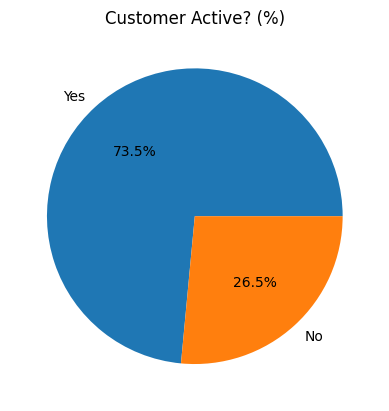

In [175]:
plt.pie(active_data, labels=['Yes', 'No'], autopct='%1.1f%%')
plt.title('Customer Active? (%)')
plt.show()

As noted above, this is an imbalanced dataset.  26.5% of customers have terminated service while 73.5% remain with the company.  I accounted for this imbalance when I split the dataset.

In [176]:
#handling missing data
internet_cols = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
combined_df[internet_cols] = combined_df[internet_cols].fillna('No')
phone_cols = ['multiplelines']
combined_df[phone_cols] = combined_df[phone_cols].fillna('No')
has_cols = ['has_internet', 'has_phone']
combined_df[has_cols] = combined_df[has_cols].fillna(0)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7025 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7025 non-null   object 
 1   paperlessbilling  7025 non-null   object 
 2   paymentmethod     7025 non-null   object 
 3   monthlycharges    7025 non-null   float64
 4   totalcharges      7025 non-null   float64
 5   gender            7025 non-null   object 
 6   seniorcitizen     7025 non-null   int64  
 7   partner           7025 non-null   object 
 8   dependents        7025 non-null   object 
 9   internetservice   7025 non-null   object 
 10  onlinesecurity    7025 non-null   object 
 11  onlinebackup      7025 non-null   object 
 12  deviceprotection  7025 non-null   object 
 13  techsupport       7025 non-null   object 
 14  streamingtv       7025 non-null   object 
 15  streamingmovies   7025 non-null   object 
 16  has_internet      7025 non-null   float64


In [177]:
train, remain = train_test_split(combined_df, test_size=0.4, random_state=21, stratify=y)
valid, test = train_test_split(remain, test_size=0.5, random_state=21)
print(f'Training Set Size: {train.shape[0]}')
print(f'Validation Set Size: {valid.shape[0]}')
print(f'Test Set Size: {test.shape[0]}')

Training Set Size: 4215
Validation Set Size: 1405
Test Set Size: 1405


In [178]:
train['active'].value_counts(normalize=True)

1    0.734994
0    0.265006
Name: active, dtype: float64

In [179]:
valid['active'].value_counts(normalize=True)

1    0.741637
0    0.258363
Name: active, dtype: float64

In [180]:
test['active'].value_counts(normalize=True)

1    0.728826
0    0.271174
Name: active, dtype: float64

The split dataset roughly preserves initial class imbalance.

In [181]:
#defining target (y) and features (X) for split dataset
train_X = train.drop(['active'], axis=1)
train_y = train['active']
valid_X = test.drop(['active'], axis=1)
valid_y = test['active']
test_X = test.drop(['active'], axis=1)
test_y = test['active']

In [182]:
def prep(train_df, cat_cols):
    train_df[cat_cols] = train_df[cat_cols].astype(str)
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    encoder.fit(train_df[cat_cols])
    return encoder

def encode(df, cat_cols, encoder):
    encoded = encoder.transform(df[cat_cols])
    oe_df = pd.DataFrame(encoded, columns=cat_cols, index=df.index)
    df_encoded = pd.concat([df.drop(columns=cat_cols), oe_df], axis=1)
    df_encoded.columns = df_encoded.columns.str.lower()
    return df_encoded

def oe (train_df, valid_df, test_df, cat_cols):
    encoder = prep(train_df, cat_cols)
    return (
        encode(train_df, cat_cols, encoder),
        encode(valid_df, cat_cols, encoder),
        encode(test_df, cat_cols, encoder)
    )

In [183]:
cat_cols = ['type', 'paperlessbilling', 'paymentmethod', 'gender', 'partner', 'dependents',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'multiplelines']
train_X, valid_X, test_X = oe(train_X, valid_X, test_X, cat_cols)

## Models

Now that the data is ready, I will create 5 different models and assess their performance using AUC-ROC.  Specifically, I will train decision tree, random forest, logistic regression, LightGBM, and CatBoost models.

### Dummy Classifier

Before creating any real models, I will run a Dummy Classifier to get a baseline AUC-ROC score.

In [184]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_X, train_y)
valid_probs = dummy.predict_proba(valid_X)[:, 1]
aucroc = roc_auc_score(valid_y, valid_probs)
print(f"Dummy AUC-ROC: {aucroc: .3f}")

Dummy AUC-ROC:  0.500


Making random predictions, the AUC-ROC is the expected 0.5.  Our data appears to be working as it should.

### Decision Tree

In [185]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 4, 10],
    'min_samples_leaf': [4, 8, 16, 24],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

dt_model = DecisionTreeClassifier(random_state=21)
random_search = RandomizedSearchCV(dt_model, param_distributions=param_grid, n_iter=20, cv=3, scoring='roc_auc', random_state=21, n_jobs=-1, verbose=0)
random_search.fit(train_X, train_y)
print("Best parameters:", random_search.best_params_)
best_dt = random_search.best_estimator_
best_dt.fit(train_X, train_y)
valid_probs = best_dt.predict_proba(valid_X)[:, 1]
aucroc = roc_auc_score(valid_y, valid_probs)
print(f"Best AUC-ROC: {aucroc: .3f}")

Best parameters: {'min_samples_split': 2, 'min_samples_leaf': 24, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Best AUC-ROC:  0.844


With min_samples_split of 2, min_samples_leaf of 24, no max_features, a max_depth of 5, gini as criterion, and balanced class_weight, the Decision Tree Classifier achieves its maximum AUC-ROC of 0.844.  This is a great start and proof that a model can quickly make quality predictions based on the dataset.

### Random Forest

In [186]:
param_grid = {
    'n_estimators': [120, 160, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [4, 8],
    'min_samples_leaf': [4, 8, 20],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}
rf_model = RandomForestClassifier(random_state=21, n_jobs=-1)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=20, cv=3, scoring='roc_auc', random_state=21, n_jobs=-1, verbose=0)
random_search.fit(train_X, train_y)
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_
best_rf.fit(train_X, train_y)
valid_probs = best_rf.predict_proba(valid_X)[:, 1]
aucroc = roc_auc_score(valid_y, valid_probs)
print(f"Best AUC-ROC: {aucroc: .3f}")

Best Parameters: {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None, 'bootstrap': True}
Best AUC-ROC:  0.850


With 200 estimators, min_samples_split of 4, min_samples_leaf of 4, using square root to determine max_features, a max_depth of 10, class_weight disabled, and bootstrapping enabled, the Random Forest exceeds the AUC-ROC of the Decision Tree at 0.85.

### Logistic Regression

In [187]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
valid_X_scaled = scaler.transform(valid_X)

In [188]:
param_grid = [
    {
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga']},
    {'penalty': ['l2'],
     'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg', 'sag']},
    {'penalty': ['elasticnet'],
     'solver': ['saga'],
     'l1_ratio': [0.1, 0.5, 0.9]
}
]

lr_model = LogisticRegression(random_state=21, max_iter=1000)
random_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0, error_score='raise')
random_search.fit(train_X_scaled, train_y)
print("Best Parameters:", random_search.best_params_)
best_lr = random_search.best_estimator_
best_lr.fit(train_X_scaled, train_y)
valid_probs = best_lr.predict_proba(valid_X)[:, 1]
aucroc = roc_auc_score(valid_y, valid_probs)
print(f"Best AUC-ROC: {aucroc: .3f}")

Best Parameters: {'penalty': 'l1', 'solver': 'saga'}
Best AUC-ROC:  0.581


Logistic regression is clearly not a good fit for this task, only achieving an AUC-ROC of 0.581.

### LightGBM

In [190]:
train_data = lgb.Dataset(train_X, label=train_y)
valid_data = lgb.Dataset(valid_X, label=valid_y, reference=train_data)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 0.1,
    'random_state': 21,
    'verbose': -1
}
num_boost_round = 1000
eval_result = {}
lgb_model = lgb.train(params, train_data, num_boost_round = num_boost_round, valid_sets = valid_data, valid_names = ['validation'], callbacks=[lgb.record_evaluation(eval_result), lgb.log_evaluation(period=0)])
best_auc = max(eval_result['validation']['auc'])
print(f"Best AUC-ROC Score: {best_auc: .3f}")

Best AUC-ROC Score:  0.891


LightGBM blows simpler models out of the water achieving a stellar AUC-ROC of 0.891.

### Cat Boost

In [191]:
train_X = pd.DataFrame(train_X)
valid_X = pd.DataFrame(valid_X)
test_X = pd.DataFrame(test_X)

In [192]:
cat = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', iterations=500, random_seed=21)
cat.fit(train_X, train_y, verbose=10)
valid_probs = cat.predict_proba(valid_X)[:, 1]
aucroc = roc_auc_score(valid_y, valid_probs)
print(f"Best AUC-ROC Score: {aucroc: .3f}")

Learning rate set to 0.035956
0:	total: 1.95ms	remaining: 971ms
10:	total: 16.6ms	remaining: 740ms
20:	total: 31.1ms	remaining: 709ms
30:	total: 46.2ms	remaining: 699ms
40:	total: 61.4ms	remaining: 687ms
50:	total: 76.6ms	remaining: 675ms
60:	total: 91ms	remaining: 655ms
70:	total: 106ms	remaining: 640ms
80:	total: 118ms	remaining: 611ms
90:	total: 130ms	remaining: 582ms
100:	total: 141ms	remaining: 557ms
110:	total: 153ms	remaining: 535ms
120:	total: 165ms	remaining: 518ms
130:	total: 176ms	remaining: 495ms
140:	total: 186ms	remaining: 475ms
150:	total: 197ms	remaining: 455ms
160:	total: 207ms	remaining: 437ms
170:	total: 218ms	remaining: 419ms
180:	total: 229ms	remaining: 403ms
190:	total: 241ms	remaining: 389ms
200:	total: 252ms	remaining: 374ms
210:	total: 263ms	remaining: 360ms
220:	total: 273ms	remaining: 345ms
230:	total: 284ms	remaining: 331ms
240:	total: 295ms	remaining: 317ms
250:	total: 306ms	remaining: 303ms
260:	total: 318ms	remaining: 291ms
270:	total: 329ms	remaining: 27

CatBoost is a clear winner for machine learning model options.  It is able to achieve an AUC-ROC of 0.899.

## Final Testing
The CatBoost model performed the best on the validation set.  Let's see how it performs with the test set.

In [193]:
test_probs = cat.predict_proba(test_X)[:, 1]
aucroc = roc_auc_score(test_y, test_probs)
print(f"Best AUC-ROC Score: {aucroc: .3f}")

Best AUC-ROC Score:  0.899


CatBoost performs equally well on the test set.

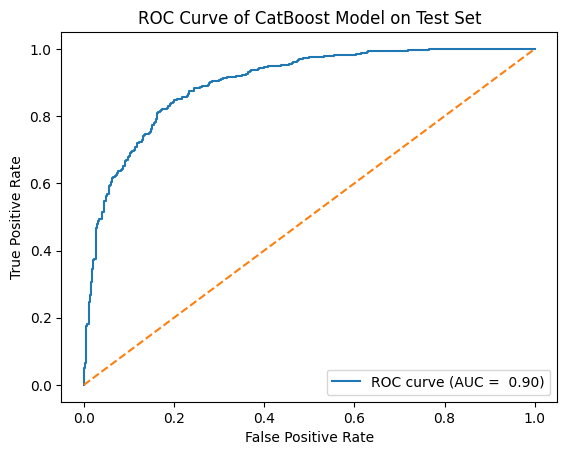

In [194]:
fpr, tpr, thresholds = roc_curve(test_y, test_probs)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score: .2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of CatBoost Model on Test Set')
plt.legend(loc='lower right')
plt.show()

## Business Insights & Conclusion

How many customers will Interconnect need to work to keep?

In [195]:
cat_test_preds = pd.Series(cat.predict(test_X))
cat_test_preds.value_counts(normalize=True)

1    0.808541
0    0.191459
dtype: float64

The CatBoost model predicts 19% of customers are at risk of leaving Interconnect.  Given the CatBoost model is able to distinguish classes very well, this is concerning.

In [196]:
fi = cat.get_feature_importance(type='PredictionValuesChange')
names = cat.feature_names_
fi_df = pd.DataFrame({'Feature': names, 'Importance': fi})
fi_df.sort_values(by='Importance', ascending=False, inplace=True)
fi_df.head(5)

,Feature,Importance
5,duration,37.083040
6,type,11.874975
0,monthlycharges,11.142728
1,totalcharges,8.086707
8,paymentmethod,5.909212


Unsurprisingly, customer duration is by far the most important predictor of whether or not a customer plans to stay with Interconnect.  Monthly charges and total charges (the amount the customer has paid over the life of the account) are also fairly strong determiners of likelihood to stay with the company.  The length of contract (type) also plays a role, especially in cases where the customer has a month-to-month plan and can leave at any time.  Similarly, payment method is a key determiner of churn, perhaps because manual payment methods are easier to stop than automatic payments.  Interestingly, the kind of service a customer has and customer demographics play very little role in a customer's likelihood to stay with the company.

Based on the predictions of the CatBoost model, Interconnect needs to move quickly to retain the business of 19% of their customers. Month-to-month customers in particular seem less likely to stay with the company, and Interconnect should consider incentivizing those customers to sign a contract that would guarantee their business for a period of time.

## Conclusion

This project aimed to help Interconnect Telecom combat customer churn using a data-driven predictive model. Through careful data cleaning, exploratory analysis, and feature engineering, I prepared a dataset reflecting the characteristics of over 7,000 customers and their plans. After comparing five machine learning models, CatBoost emerged as the top performer with an impressive AUC-ROC score of 0.904, indicating strong predictive capability even in the face of significant class imbalance.

The model reveals that customer tenure, monthly charges, and total charges are the most influential factors in predicting churn, with contract type also playing a key role. Notably, customers on month-to-month contracts are seemingly more likely to terminate service than those with longer-term agreements.

The CatBoost model estimates that 1/5 of current customers are at risk of leaving—a sizable portion that Interconnect cannot afford to ignore. By targeting high-risk customers, especially those with flexible contracts, Interconnect can proactively use retention offers like discounted service with an annual contract to ensure customers stay with the company longer.

With this predictive model in place, Interconnect is equipped to shift from reactive customer management to proactive churn prevention.